# Data Science Capstone 
## Initialize project  
#### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import time

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#conda install geopandas
#import geopandas as gpd

import numpy as np
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Matplotlib version:  3.0.3
Libraries imported.


## Get Wellbeing Toronto Healthy Food Data with Geocodes  
#### Load Toronto "Healthy Food Index" data  

Sourced from http://map.toronto.ca/wellbeing

In [2]:
# use cleansed csv file
hlthdata ="wellbeing_toronto.csv"
dfhlt = pd.read_csv(hlthdata)    #df = pd.read_excel(PCodeData)  # use this for Excel file
dfhlt.drop(['Combined Indicators'], axis=1, inplace = True)
dfhlt.head()

,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index
0,West Humber-Clairville,1.0,33312.0,23.82
1,Mount Olive-Silverstone-Jamestown,2.0,32954.0,37.57
2,Thistletown-Beaumond Heights,3.0,10360.0,42.26
3,Rexdale-Kipling,4.0,10529.0,23.31
4,Elms-Old Rexdale,5.0,9456.0,24.71


In [3]:
dfhlt.shape

(140, 4)

#### Get Neighbourhood Geocodes
Testing of neighbourhood names indicate that the hyphenated neighbourhoods are localized and generally not recognized by geocoding services (e.g. Nominatim). Better results were achieved on searches for the individual segments of the hyphenated names. The following process will be used to optimize geocoding results.

1. split hyphenated
2. get geocodes
3. eliminate neighbourhoods without geocodes
4. eliminate rows with duplicate neighbourhood ids  

This process maximizes the neighbourhoods with found geocodes.  

##### 1. Split hypenated neighbourhood names

In [4]:
dfh1 = \
(dfhlt.set_index(dfhlt.columns.drop('Neighbourhood',1).tolist())
   .Neighbourhood.str.split('-', expand=True)
   .stack()
   .reset_index()
   .rename(columns={0:'Neighbourhood'})
   .loc[:, dfhlt.columns]
)
dfh1.shape

(206, 4)

In [5]:
dfh1.head()

,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index
0,West Humber,1.0,33312.0,23.82
1,Clairville,1.0,33312.0,23.82
2,Mount Olive,2.0,32954.0,37.57
3,Silverstone,2.0,32954.0,37.57
4,Jamestown,2.0,32954.0,37.57


##### 2. Get geocodes  
This section is performed once to generate the TorontoDhf2PCodes.csv file.  
These code blocks are then disabled.  
Subsequently the file is read into dfh3.  

#Code block - initialize new dataframe to retain dfh1   
dfh2 = dfh1  
dfh2.head()

#Code block - initialize Lat, Long columns to populate below
dfh2['Lat']=0.0
dfh2['Long']=0.0
dfh2.head()

#Code block - Open source geocoding from OpenStreetMap data - nominatim.org  
    #use once and then save to file  
    #use file in subsequent iterations
for n in range(len(dfh2)):  
    if (dfh2['Lat'][n] == 0.0): # if geocoder times out, this will allow this block to be run starting from last entry  
        try:  
            address=(dfh2['Neighbourhood'][n]+ ', '+'Toronto ON')   
            geolocator = Nominatim()              
            location = geolocator.geocode(address)  
            latitude = location.latitude   
            longitude = location.longitude    
            dfh2['Lat'][n]=latitude   
            dfh2['Long'][n]=longitude  
        except AttributeError:  
            latitude=1.00  # this changes value to allow for block to be rerun - see line 2 above  
            longitude=0  
            dfh2['Lat'][n]=latitude   
            dfh2['Long'][n]=longitude  
            #print(n,latitude,longitude)  
        print(address, n, latitude, longitude)  
        #time.sleep(1) # add 1/2 second delay   

print('Geodata completed')

#Code block - verify results  
dfh2.head()

#Code Block - save dfh2 to file  
dfh2.to_csv('TorontoDhf2PCodes.csv', index=False)

In [6]:
# on subsequent iterations get file from storage
getTO_PCodes ="TorontoDhf2PCodes.csv"
dfh3 = pd.read_csv(getTO_PCodes)
dfh3.head()  # verify results

,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index,Lat,Long
0,West Humber,1.0,33312.0,23.82,43.724321,-79.512446
1,Clairville,1.0,33312.0,23.82,1.000000,0.000000
2,Mount Olive,2.0,32954.0,37.57,43.653963,-79.387207
3,Silverstone,2.0,32954.0,37.57,43.746007,-79.600236
4,Jamestown,2.0,32954.0,37.57,43.653963,-79.387207


In [7]:
dfh3.shape

(206, 6)

##### 3. Eliminate neighbourhoods without geocodes

In [8]:
# Drop rows with 'Lat' = 1.0 (geocodes process above set 'Lat' to 1.0 if geocode was not available)
dfh3 = dfh3[dfh3['Lat'] != 1.0].reset_index(drop=True)
dfh3.head(10)

,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index,Lat,Long
0,West Humber,1.0,33312.0,23.82,43.724321,-79.512446
1,Mount Olive,2.0,32954.0,37.57,43.653963,-79.387207
2,Silverstone,2.0,32954.0,37.57,43.746007,-79.600236
3,Jamestown,2.0,32954.0,37.57,43.653963,-79.387207
4,Thistletown,3.0,10360.0,42.26,43.737266,-79.565317
5,Rexdale,4.0,10529.0,23.31,43.721362,-79.565513
6,Kipling,4.0,10529.0,23.31,43.637593,-79.535494
7,Elms,5.0,9456.0,24.71,43.696998,-79.521883
8,Old Rexdale,5.0,9456.0,24.71,43.721362,-79.565513
9,Kingsview Village,6.0,22000.0,35.69,43.699539,-79.556346


In [9]:
dfh3.shape

(193, 6)

##### 4. Eliminate rows with duplicate neighbourhood ids

In [10]:
dfh4 = dfh3.drop_duplicates(['Neighbourhood Id']).reset_index(drop=True)
dfh4.shape

(136, 6)

In [11]:
dfh4.head(10)

,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index,Lat,Long
0,West Humber,1.0,33312.0,23.82,43.724321,-79.512446
1,Mount Olive,2.0,32954.0,37.57,43.653963,-79.387207
2,Thistletown,3.0,10360.0,42.26,43.737266,-79.565317
3,Rexdale,4.0,10529.0,23.31,43.721362,-79.565513
4,Elms,5.0,9456.0,24.71,43.696998,-79.521883
5,Kingsview Village,6.0,22000.0,35.69,43.699539,-79.556346
6,Willowridge,7.0,22156.0,30.46,43.675559,-79.569896
7,Humber Heights,8.0,10948.0,32.82,43.698179,-79.523277
8,Edenbridge,9.0,15535.0,46.41,43.682338,-79.510804
9,Princess,10.0,11051.0,39.52,43.647059,-79.389248


#### Result  
is a dataframe containing the cleansed Wellbeing Toronto data with neighbourhoods, population, healthy food index, and lat/long.  
The result contains 136 neighbourhoods of the original 140 neighbourhoods.  

#### Review results 
##### Map Wellbeing Toronto neighbourhoods 

In [12]:
# set map location
address = 'Downtown Toronto, ON'

geolocator = Nominatim()#user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Downtown Toronto, ON are 43.655115, -79.380219.


In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
radius = 4

# add markers to map
for lat, lng, nid, neighbourhood in zip(dfh4['Lat'], dfh4['Long'], dfh4['Neighbourhood Id'], dfh4['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, nid)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=radius,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        title='Title',
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Get Foursquare venues for Wellbeing Toronto neighbourhoods

#### Initialize Fourshare API variables

In [14]:
CLIENT_ID = '4DRNWK00JSGGFSQQDVK5VEGMIQSJ3FQSMZ51FDQWNDVTITRB' # your Foursquare ID
CLIENT_SECRET = 'YOXXHRRSRQ12PFGELAKFOV55FACYOAFO01XXUCXIWD0QXLML' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4DRNWK00JSGGFSQQDVK5VEGMIQSJ3FQSMZ51FDQWNDVTITRB
CLIENT_SECRET:YOXXHRRSRQ12PFGELAKFOV55FACYOAFO01XXUCXIWD0QXLML


#### Load neighbourhood data

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
TOWbg_venues = getNearbyVenues(names=dfh4['Neighbourhood'],
                                   latitudes=dfh4['Lat'],
                                   longitudes=dfh4['Long']
                                  )

In [17]:
print(TOWbg_venues.shape)
TOWbg_venues.head()

(3186, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Humber,43.724321,-79.512446,Tim Hortons,43.722802,-79.509489,Coffee Shop
1,West Humber,43.724321,-79.512446,Dollarama,43.721220,-79.510535,Discount Store
2,West Humber,43.724321,-79.512446,Subway,43.721105,-79.510082,Sandwich Place
3,West Humber,43.724321,-79.512446,Tim Hortons,43.721341,-79.511778,Coffee Shop
4,West Humber,43.724321,-79.512446,Pizza Pizza,43.720218,-79.512691,Pizza Place


In [18]:
print('There are {} unique categories.'.format(len(TOWbg_venues['Venue Category'].unique())))

There are 291 unique categories.


####  
#### Merge food category ratings w/ Foursquare venue data

In [19]:
# import saved food category ratings file
foodfile='4Scategories_food.csv'
frsq_food = pd.read_csv(foodfile)
print('Shape is ', frsq_food.shape)
frsq_food.head()  # verify results

Shape is  (115, 3)


,Venue Category,Neighbourhood,rating
0,Afghan Restaurant,3,2
1,African Restaurant,2,2
2,American Restaurant,24,1
3,Asian Restaurant,26,2
4,BBQ Joint,15,1


In [20]:
# merge food category ratings with Foursquare venue data
dfWBgFood = pd.merge(TOWbg_venues, 
 frsq_food, 
 how='inner', 
 on='Venue Category')
dfWBgFood.head()

,Neighbourhood_x,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighbourhood_y,rating
0,West Humber,43.724321,-79.512446,Tim Hortons,43.722802,-79.509489,Coffee Shop,214,2
1,West Humber,43.724321,-79.512446,Tim Hortons,43.721341,-79.511778,Coffee Shop,214,2
2,Mount Olive,43.653963,-79.387207,The Library Specialty Coffee,43.654413,-79.390902,Coffee Shop,214,2
3,Mount Olive,43.653963,-79.387207,M Square Coffee Co,43.651218,-79.383555,Coffee Shop,214,2
4,Mount Olive,43.653963,-79.387207,HotBlack Coffee,43.650364,-79.388669,Coffee Shop,214,2


In [21]:
#rename columns
dfWBgFood.rename(columns={'Neighbourhood_x':'Neighbourhood',
                          'Neighbourhood Latitude':'Nbrhd Lat',
                          'Neighbourhood Longitude':'Nbrhd Long',
                          }, 
                 inplace=True)

In [22]:
print(dfWBgFood.shape)
dfWBgFood.head()

(1763, 9)


,Neighbourhood,Nbrhd Lat,Nbrhd Long,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighbourhood_y,rating
0,West Humber,43.724321,-79.512446,Tim Hortons,43.722802,-79.509489,Coffee Shop,214,2
1,West Humber,43.724321,-79.512446,Tim Hortons,43.721341,-79.511778,Coffee Shop,214,2
2,Mount Olive,43.653963,-79.387207,The Library Specialty Coffee,43.654413,-79.390902,Coffee Shop,214,2
3,Mount Olive,43.653963,-79.387207,M Square Coffee Co,43.651218,-79.383555,Coffee Shop,214,2
4,Mount Olive,43.653963,-79.387207,HotBlack Coffee,43.650364,-79.388669,Coffee Shop,214,2


In [23]:
print('There are {} unique categories.'.format(len(dfWBgFood['Venue Category'].unique())))
dfWBgFood.columns

There are 115 unique categories.


Index(['Neighbourhood', 'Nbrhd Lat', 'Nbrhd Long', 'Venue', 'Venue Latitude',
       'Venue Longitude', 'Venue Category', 'Neighbourhood_y', 'rating'],
      dtype='object')

####   
#### Merge Food Venue data with Wellbeing Toronto data

In [24]:
# merge food venue data wtih Wellbeing Toronto
dfMerg = pd.merge(dfh4, 
 dfWBgFood, 
 how='inner', 
 on='Neighbourhood')
dfMerg.shape

(1961, 14)

In [25]:
print('Shape is ', dfMerg.shape)
dfMerg.head()

Shape is  (1961, 14)


,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index,Lat,Long,Nbrhd Lat,Nbrhd Long,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighbourhood_y,rating
0,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,43.724321,-79.512446,Tim Hortons,43.722802,-79.509489,Coffee Shop,214,2
1,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,43.724321,-79.512446,Tim Hortons,43.721341,-79.511778,Coffee Shop,214,2
2,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,43.724321,-79.512446,Subway,43.721105,-79.510082,Sandwich Place,71,2
3,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,43.724321,-79.512446,7-Eleven,43.720420,-79.513736,Convenience Store,35,1
4,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,43.724321,-79.512446,Food Basics,43.721815,-79.510182,Supermarket,17,2


In [26]:
dfMerg.columns

Index(['Neighbourhood', 'Neighbourhood Id', 'Total Population',
       'Healthy Food Index', 'Lat', 'Long', 'Nbrhd Lat', 'Nbrhd Long', 'Venue',
       'Venue Latitude', 'Venue Longitude', 'Venue Category',
       'Neighbourhood_y', 'rating'],
      dtype='object')

In [27]:
# drop duplicate lat/long columns
dfMerg.drop(['Nbrhd Lat', 'Nbrhd Long'], axis=1, inplace=True)
print(dfMerg.shape)
dfMerg.head()

(1961, 12)


,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index,Lat,Long,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighbourhood_y,rating
0,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,Tim Hortons,43.722802,-79.509489,Coffee Shop,214,2
1,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,Tim Hortons,43.721341,-79.511778,Coffee Shop,214,2
2,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,Subway,43.721105,-79.510082,Sandwich Place,71,2
3,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,7-Eleven,43.720420,-79.513736,Convenience Store,35,1
4,West Humber,1.0,33312.0,23.82,43.724321,-79.512446,Food Basics,43.721815,-79.510182,Supermarket,17,2


## Create Choropleth map of Toronto neighbourhoods
### A. Prepare HFI mapping data - dfToHfi 

In [28]:
# Create 2 dataframes from Merged data
# create Toronto Neighbourhoods with Healthy Food Index 
dfToHfi = dfMerg.groupby(['Neighbourhood']).mean()
dfToHfi.drop(['Neighbourhood Id', 'Total Population', 'Lat', 'Long', 'Venue Latitude', 'Venue Longitude', 'Neighbourhood_y','rating' ], axis=1, inplace=True)
dfToHfi.reset_index(inplace=True)
dfToHfi.head()

,Neighbourhood,Healthy Food Index
0,Agincourt North,38.09
1,Agincourt South,35.26
2,Alderwood,11.41
3,Annex,38.85
4,Bathurst Manor,18.80


In [29]:
# compare the HFI min/max
print('Healthy Food Index Maximum:')
print(dfToHfi.max())
print('Healthy Food Index Minimum:')
print(dfToHfi.min())
print(dfToHfi.shape)

Healthy Food Index Maximum:
Neighbourhood         Yorkdale
Healthy Food Index       53.48
dtype: object
Healthy Food Index Minimum:
Neighbourhood         Agincourt North
Healthy Food Index               6.67
dtype: object
(116, 2)


### B. Choropleth map 1 - Neighbourhood Healthy Food Index values

In [30]:
# get Toronto Geolocation for maps
to_geo = r'toronto-geojson.json' # geojson file
print('latitude is {} and longitude is {}'.format(
latitude,
longitude) )

latitude is 43.655115 and longitude is -79.380219


In [31]:
# Create Choropleth map of Toronto by neighbourhood Healthy Food Index values
# set initial zoom
zoom = 10

# add
fill_color = 'YlOrRd'
fill_opacity = 0.7
line_opacity=0.2
LegendName = 'Toronto, Neighbourhood Healthy Food Index'

#also 
#define a legend and 
#use the default threshold scale.

# create map and display it
to_map = folium.Map(location=[latitude, longitude], zoom_start=zoom)
to_map.choropleth(
    geo_data=to_geo,
    data=dfToHfi,
    columns=['Neighbourhood', 'Healthy Food Index'],
    #columns=['FULLHOOD'],
    key_on='feature.properties.HOOD',
    fill_color=fill_color, 
    fill_opacity=fill_opacity, 
    line_opacity=line_opacity,
    legend_name=LegendName
)

# display the map of Toronto 
to_map

### C. Prepare Neighbourhood Venue Average Health Ratings mapping data - dfToRate

In [32]:
# create Toronto Neighbourhoods with Venue Average Health Rating
dfToRate = dfMerg.groupby(['Neighbourhood']).mean()
dfToRate.drop(['Neighbourhood Id', 'Total Population', 'Healthy Food Index', 'Lat', 'Long', 'Venue Latitude', 'Venue Longitude', 'Neighbourhood_y' ], axis=1, inplace=True)
dfToRate.reset_index(inplace=True)
dfToRate.head()

,Neighbourhood,rating
0,Agincourt North,1.578947
1,Agincourt South,2.000000
2,Alderwood,1.666667
3,Annex,1.785714
4,Bathurst Manor,1.000000


In [33]:
print('Venue Health Rating Maximum:')
print(dfToRate.max())
print('Venue Health Rating Minimum:')
print(dfToRate.min())

Venue Health Rating Maximum:
Neighbourhood    Yorkdale
rating                  3
dtype: object
Venue Health Rating Minimum:
Neighbourhood    Agincourt North
rating                         1
dtype: object


### D. Choropleth map 2 - Neighbourhood Venue Average Health Ratings

In [34]:
# Create Choropleth map of Toronto by neighbourhood Healthy Food Index values
# set initial zoom
zoom = 10

# add
fill_color = 'YlOrRd'
fill_opacity = 0.7
line_opacity=0.2
LegendName = 'Toronto FourSquare Venue Health Ratings'

# also 
# define a legend and 
# use the default threshold scale.

# create map and display it
to_map = folium.Map(location=[latitude, longitude], zoom_start=zoom)
to_map.choropleth(
    geo_data=to_geo,
    data=dfToRate,
    columns=['Neighbourhood', 'rating'],
    key_on='feature.properties.HOOD',
    fill_color=fill_color, 
    fill_opacity=fill_opacity, 
    line_opacity=line_opacity,
    legend_name=LegendName
)

# display the map of Toronto
to_map

The two choropleth maps illustrate significant differences between the neighbourhoods' Healthy Food Index Scores and the venues' average health ratings. The Health Food Index map indicates more neighbourhoods at the healthier end of the scale (darker areas) compared to the average health ratings of the venues in those neighbourhoods.   
## Create Histograms of Toronto neighbourhood distributions
### Histogram 1 - Neighbourhood Healthy Food Index Scores

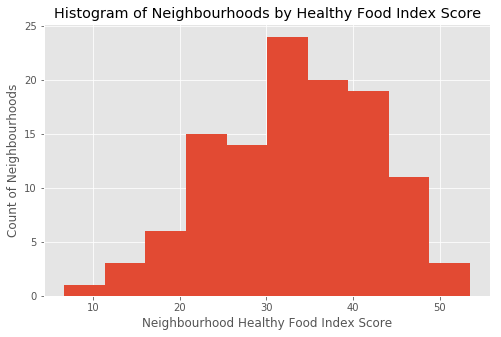

In [35]:
# create histogram of neighbourhoods Healthy food index score distributions
dfToHfi['Healthy Food Index'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Neighbourhoods by Healthy Food Index Score') # add a title to the histogram
plt.ylabel('Count of Neighbourhoods') # add y-label
plt.xlabel('Neighbourhood Healthy Food Index Score') # add x-label

plt.show()

### Histogram 2 - Neighbourhood Food Venue Average Health Ratings

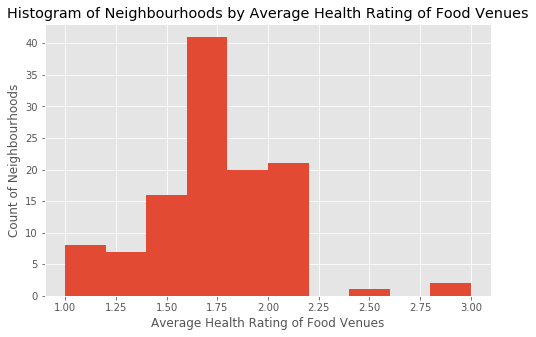

In [36]:
# create histogram of neighbourhoods venues' average health ratings distributions
dfToRate['rating'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Neighbourhoods by Average Health Rating of Food Venues' ) # add a title to the histogram
plt.ylabel('Count of Neighbourhoods') # add y-label
plt.xlabel('Average Health Rating of Food Venues') # add x-label

plt.show()

The two histograms affirm the differences between the neighbourhoods' Healthy Food Index Scores and the venues' average health ratings observed in the choropleth maps. The Health Food Index histogram illustrates skewing of neighbourhoods' Healthy Food Index more toward the upper range (healthier) compared to the average health ratings of the food venues in those neighbourhoods shown in the second histogram.  
# Clustering of Neighbourhoods
##  Prepare two dataframes for initial comparison  
One of these dataframes will be used for cluster comparisons, based on both data and business factors. This decision is explained further below.
### Dataframe 1 - Neighbourhoods with Healthy Food Index >= 38

In [37]:
# Drop rows with Healthy Food Index < 38
dfM4 = dfMerg[dfMerg['Healthy Food Index'] >= 38].reset_index(drop=True)
print(dfM4.shape)
dfM4.head()

(729, 12)


,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index,Lat,Long,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighbourhood_y,rating
0,Thistletown,3.0,10360.0,42.26,43.737266,-79.565317,Tim Hortons,43.737881,-79.566891,Coffee Shop,214,2
1,Thistletown,3.0,10360.0,42.26,43.737266,-79.565317,Food Basics,43.735045,-79.559913,Supermarket,17,2
2,Thistletown,3.0,10360.0,42.26,43.737266,-79.565317,Dairy Queen,43.736232,-79.565309,Fast Food Restaurant,69,1
3,Thistletown,3.0,10360.0,42.26,43.737266,-79.565317,Rajdhani Sweets & Restaurant,43.738409,-79.566246,Indian Restaurant,36,2
4,Thistletown,3.0,10360.0,42.26,43.737266,-79.565317,Madras Dosa Hut,43.737156,-79.566460,Indian Restaurant,36,2


In [38]:
print('There are {} unique neighbourhoods.'.format(len(dfM4['Neighbourhood'].unique())))

There are 38 unique neighbourhoods.


### Dataframe 2 - Neighbourhoods with Healthy Food Venues (Rating = 3)

In [39]:
# Create dataframe from Merged data for Healthy Food Venues
# keep rows where venue rating equals 3 (healthy) 
dfM4b = dfMerg[dfMerg['rating'] ==3].reset_index(drop=True)
print(dfM4b.shape)
dfM4b.head()

(245, 12)


,Neighbourhood,Neighbourhood Id,Total Population,Healthy Food Index,Lat,Long,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighbourhood_y,rating
0,Mount Olive,2.0,32954.0,37.57,43.653963,-79.387207,Japango,43.655268,-79.385165,Sushi Restaurant,68,3
1,Mount Olive,2.0,32954.0,37.57,43.653963,-79.387207,JaBistro,43.649687,-79.388090,Sushi Restaurant,68,3
2,Mount Olive,2.0,32954.0,37.57,43.653963,-79.387207,Gallery Sushi,43.654481,-79.390635,Sushi Restaurant,68,3
3,Mount Olive,2.0,32954.0,37.57,43.653963,-79.387207,Tachi,43.650596,-79.383396,Sushi Restaurant,68,3
4,Mount Olive,2.0,32954.0,37.57,43.653963,-79.387207,Tsujiri,43.655374,-79.385354,Tea Room,19,3


In [40]:
print('There are {} unique neighbourhoods.'.format(len(dfM4b['Neighbourhood'].unique())))

There are 59 unique neighbourhoods.


### Dataframe choice  
Choosing one of these dataframes for clustering comparison is both a data and business decision.  
From a data perspective, the clustering comparisons would benefit from the greater number of neighbourhoods offered by the second dataframe over the first (58 : 38), while still providing a sufficient number of venues for valid clustering.  
The business perspective however is more significant. Choosing to compare clusters based on only healthy food venues (rating = 3) targets competitive businesses. This follows the principle of The Central Place Theory (Steif, 2013), which suggests the economic advantage of establishing a venue near competitors, particularly in larger urban centers. At this same time, the cluster comparisons can factor in the neighbourhood population and HFI indicators to highlight neighbourhoods of greater market opportunity. This point will be discussed further in the conclusions.  
Considering both the data and business perspectives, the choice for cluster comparison will focus on the second dataframe, namely the neighbourhoods with only healthy food venues (rating = 3).  
  
Steif, Ken. 2013. "Why Do Certain Retail Stores Cluster Together?", Planetizen, Oct. 2013. Available at https://www.planetizen.com/node/65765.    
## Prepare cluster dataframe  
### Encode venue categories by column  

In [41]:
# one hot encoding
toronto_encode = pd.get_dummies(dfM4b[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_encode['Neighbourhood'] = dfM4b['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_encode.columns[-1]] + list(toronto_encode.columns[:-1])
toronto_encode = toronto_encode[fixed_columns]
print('Shape is ',toronto_encode.shape)
toronto_encode.head()

Shape is  (245, 21)


,Neighbourhood,Butcher,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store,Juice Bar,Market,Mediterranean Restaurant,Middle Eastern Restaurant,Organic Grocery,Salad Place,Smoothie Shop,Soup Place,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant
0,Mount Olive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Mount Olive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Mount Olive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Mount Olive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Mount Olive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [42]:
toronto_grouped = toronto_encode.groupby('Neighbourhood').mean().reset_index()
print('Shape is ',toronto_encode.shape)
toronto_grouped.head()

Shape is  (245, 21)


,Neighbourhood,Butcher,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store,Juice Bar,Market,Mediterranean Restaurant,Middle Eastern Restaurant,Organic Grocery,Salad Place,Smoothie Shop,Soup Place,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant
0,Agincourt North,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annex,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.0,0.2,0.0,0.2
2,Bay Street Corridor,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
3,Bayview Village,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Briar Hill,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


####  
#### Return 10 most common venues

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
print('Shape is ',neighbourhoods_venues_sorted.shape)
neighbourhoods_venues_sorted.head()

Shape is  (59, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Juice Bar,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
1,Annex,Greek Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Health Food Store,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant
2,Bay Street Corridor,Sushi Restaurant,Mediterranean Restaurant,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop
3,Bayview Village,Fish Market,Vegetarian / Vegan Restaurant,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
4,Briar Hill,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Health Food Store,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant


####   
#### Create clusters and merge cluster labels

In [45]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 1, 1, 1, 1, 1, 3, 1, 1, 1], dtype=int32)

In [46]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#drop extraneous columns
toronto_merged = dfM4b.drop(['Neighbourhood Id', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Neighbourhood_y','rating'], axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

#toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head() # check the last columns!

,Neighbourhood,Total Population,Healthy Food Index,Lat,Long,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mount Olive,32954.0,37.57,43.653963,-79.387207,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
1,Mount Olive,32954.0,37.57,43.653963,-79.387207,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
2,Mount Olive,32954.0,37.57,43.653963,-79.387207,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
3,Mount Olive,32954.0,37.57,43.653963,-79.387207,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
4,Mount Olive,32954.0,37.57,43.653963,-79.387207,Tea Room,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market


In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Lat'], toronto_merged['Long'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters
### Cluster 1 - Details

In [48]:
clustLbl=0
print('Shape is: ',toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl].shape)
toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

Shape is:  (3, 17)


,Neighbourhood,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Willowridge,Juice Bar,0,Juice Bar,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
178,Dovercourt,Juice Bar,0,Juice Bar,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
241,Agincourt North,Juice Bar,0,Juice Bar,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store


### Cluster 1 - Neighbourhood groups

In [49]:
# Group by Neighbourhood w/o category details
toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl].groupby(['Neighbourhood','Total Population','Healthy Food Index']).count() #, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,,,Lat,Long,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,Total Population,Healthy Food Index,,,,,,,,,,,,,,
Agincourt North,29113.0,38.09,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Dovercourt,36625.0,35.06,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Willowridge,22156.0,30.46,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Cluster 2 - Details

In [50]:
clustLbl=1
print('Shape is: ',toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl].shape)
toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

Shape is:  (212, 17)


,Neighbourhood,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mount Olive,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
1,Mount Olive,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
2,Mount Olive,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
3,Mount Olive,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
4,Mount Olive,Tea Room,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
5,Mount Olive,Middle Eastern Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
6,Mount Olive,Vegetarian / Vegan Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
7,Mount Olive,Greek Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
8,Mount Olive,Juice Bar,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Greek Restaurant,Tea Room,Juice Bar,Organic Grocery,Salad Place,Mediterranean Restaurant,Market
12,Princess,Sushi Restaurant,1,Sushi Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Caribbean Restaurant,Mediterranean Restaurant,Juice Bar,Salad Place,Soup Place,Organic Grocery,Smoothie Shop


### Cluster 2 - Neighbourhood groups

In [51]:
# Group by Neighbourhood w/o category details
toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl].groupby(['Neighbourhood','Total Population','Healthy Food Index']).count() #, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Lat  Long  \
Neighbourhood       Total Population Healthy Food Index              
Annex               30526.0          38.85                 5     5   
Bay Street Corridor 25797.0          24.83                 6     6   
Bayview Village     21396.0          32.12                 1     1   
Briar Hill          14257.0          34.23                 1     1   
Cabbagetown         11669.0          43.71                 2     2   
Church              31340.0          33.50                 6     6   
Corso Italia        14133.0          37.94                 2     2   
Danforth            7804.0           42.51                 9     9   
                    9666.0           32.16                 9     9   
                    17180.0          24.56                 9     9   
Forest Hill North   12806.0          29.11                 1     1   
Forest Hill South   10732.0          18.49                 1     1   
Glenfield           30491.0          41.05                 9     9   
Greenwood           14417.0          44.29                 2     2   
High Park North     22162.0          40.24                 3     3   
Humewood            14365.0          32.85                 4     4   
Islington           43965.0          31.01                 2     2   
Junction Area       14366.0          44.09                 2     2   
Kingsway South      9271.0           43.15                 3     3   
Lawrence Park North 14607.0          52.03                 5     5   
Lawrence Park South 15179.0          37.53                 5     5   
Milliken            26572.0          25.25                 1     1   
Moss Park           20506.0          42.76                 2     2   
Mount Olive         32954.0          37.57                 9     9   
Mount Pleasant East 16775.0          50.40                 6     6   
Mount Pleasant West 29658.0          41.60                 6     6   
Newtonbrook East    16097.0          29.12                 5     5   
Newtonbrook West    23831.0          26.14                 5     5   
Niagara             31180.0          34.94                 5     5   
Palmerston          13826.0          45.81                 2     2   
Princess            11051.0          39.52                10    10   
Regent Park         10803.0          42.52                 1     1   
Roncesvalles        14974.0          44.85                 7     7   
St.Andrew           17812.0          18.23                 8     8   
The Beaches         21567.0          31.53                 4     4   
The Island          65913.0          31.61                 9     9   
Trinity             16556.0          35.45                 9     9   
Victoria Village    17510.0          26.90                 1     1   
West Hill           27392.0          28.06                 2     2   
Willowdale East     50434.0          28.90                 1     1   
Willowdale West     16936.0          17.67                 1     1   
Woodbine            7865.0           27.87                 2     2   
Wychwood            14349.0          40.49                 6     6   
Yonge               11817.0          31.95                10    10   
                    12528.0          32.65                10    10   
Yorkdale            14804.0          21.66                 3     3   

                                                         Venue Category  \
Neighbourhood       Total Population Healthy Food Index                   
Annex               30526.0          38.85                            5   
Bay Street Corridor 25797.0          24.83                            6   
Bayview Village     21396.0          32.12                            1   
Briar Hill          14257.0          34.23                            1   
Cabbagetown         11669.0          43.71                            2   
Church              31340.0          33.50                            6   
Corso Italia        14133.0          37.94                            2   
Danforth            7

### Cluster 3 - Details

In [52]:
clustLbl=2
print('Shape is: ',toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl].shape)
toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

Shape is:  (11, 17)


,Neighbourhood,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Thistletown,Caribbean Restaurant,2,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Tea Room,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
10,Thistletown,Caribbean Restaurant,2,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Tea Room,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
36,York University Heights,Caribbean Restaurant,2,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Tea Room,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
55,Flemingdon Park,Caribbean Restaurant,2,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Tea Room,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
56,Parkwoods,Caribbean Restaurant,2,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Tea Room,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
106,North St.James Town,Caribbean Restaurant,2,Caribbean Restaurant,Market,Vegetarian / Vegan Restaurant,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant
107,North St.James Town,Market,2,Caribbean Restaurant,Market,Vegetarian / Vegan Restaurant,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant
161,South Parkdale,Tea Room,2,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Vegetarian / Vegan Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
162,South Parkdale,Caribbean Restaurant,2,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Vegetarian / Vegan Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
163,South Parkdale,Eastern European Restaurant,2,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Vegetarian / Vegan Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store


### Cluster 3 - Neighbourhood groups

In [53]:
# Group by Neighbourhood w/o category details
toronto_merged.loc[toronto_merged['Cluster Labels'] ==clustLbl].groupby(['Neighbourhood','Total Population','Healthy Food Index']).count() #, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,,,Lat,Long,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,Total Population,Healthy Food Index,,,,,,,,,,,,,,
Flemingdon Park,21933.0,21.66,1,1,1,1,1,1,1,1,1,1,1,1,1,1
North St.James Town,18615.0,34.03,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Parkwoods,34805.0,33.60,1,1,1,1,1,1,1,1,1,1,1,1,1,1
South Parkdale,21849.0,26.84,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Tam O'Shanter,27446.0,41.37,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Thistletown,10360.0,42.26,2,2,2,2,2,2,2,2,2,2,2,2,2,2
York University Heights,27593.0,47.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Cluster 4 - Details

In [54]:
clustLbl=3
print('Shape is: ',toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl].shape)
toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

Shape is:  (19, 17)


,Neighbourhood,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
99,North Riverdale,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
100,South Riverdale,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Tea Room,Caribbean Restaurant,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Health Food Store
129,Kensington,Middle Eastern Restaurant,3,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Organic Grocery,Middle Eastern Restaurant,Gourmet Shop,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant
130,Kensington,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Organic Grocery,Middle Eastern Restaurant,Gourmet Shop,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant
131,Kensington,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Organic Grocery,Middle Eastern Restaurant,Gourmet Shop,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant
132,Kensington,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Organic Grocery,Middle Eastern Restaurant,Gourmet Shop,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant
133,Kensington,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Organic Grocery,Middle Eastern Restaurant,Gourmet Shop,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant
134,Kensington,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Organic Grocery,Middle Eastern Restaurant,Gourmet Shop,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant
135,Kensington,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Organic Grocery,Middle Eastern Restaurant,Gourmet Shop,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant
136,Kensington,Vegetarian / Vegan Restaurant,3,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Organic Grocery,Middle Eastern Restaurant,Gourmet Shop,Health Food Store,Eastern European Restaurant,Fish Market,Fruit & Vegetable Store,Gluten-free Restaurant


### Cluster 4 - Neighbourhood groups

In [55]:
# Group by Neighbourhood w/o category details
toronto_merged.loc[toronto_merged['Cluster Labels'] == clustLbl].groupby(['Neighbourhood','Total Population','Healthy Food Index']).count() #, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,,,Lat,Long,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,Total Population,Healthy Food Index,,,,,,,,,,,,,,
Casa Loma,10968.0,32.33,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Dufferin Grove,11785.0,40.07,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Kensington,17945.0,37.57,13,13,13,13,13,13,13,13,13,13,13,13,13,13
Little Portugal,15559.0,37.58,1,1,1,1,1,1,1,1,1,1,1,1,1,1
North Riverdale,11916.0,47.17,1,1,1,1,1,1,1,1,1,1,1,1,1,1
South Riverdale,27876.0,45.86,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# This concludes this workbook   
Results and discussion is contained in the complete report.